# Принятие решений в бизнесе

Перед нами поставлена задача изучить и приоретизировать гипотезы, которые сформулировали и оценили по критериям Reach, Impact, Confidence, Efforts наши коллеги. Также у нас есть данные о проведении A/B теста одной из гипотез, которые необходимо визуализировать и дать оценку эффективности предлагаемых изменений.
<br> У нас есть три исходных файла: гипотезы с критериями, данные о заказах, разделенные по группам и данные о посетителях, разделенные по группам.
<br> Перед началом работы с данными мы изучим содержимое исходных файлов и проведем необходимую предобработку.
<br> В процессе приоретизации гипотез мы применим фреймворки ICE и RICE и выберем гипотезу, набравшую наибольшее количество баллво в совокупности.
<br> В процессе оценки A/B теста мы построим графики для сравнения среднего количества заказов и среднего чека в разных группах используя полные данные, а потом уберем экстремумы.
<br> Также посчитаем p-value и относительное различие для каждого варианта, чтобы подтвердить или опровергнуть идентичность выборок по группам.
<br> Изучив результат, сделаем вывод о состоятельности гипотезы.

Для начала выгрузим необходимые библиотеки и загрузим исходные данные.

In [1]:
import pandas as pd
import numpy as np
import math as mth
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import openpyxl
from pandas.plotting import register_matplotlib_converters
from matplotlib.ticker import FormatStrFormatter
from matplotlib.pyplot import figure
import scipy.stats as stats
import warnings

register_matplotlib_converters()

pd.options.display.max_colwidth = 110

Загрузим исходные данные (вырианты для просмотра локально и через браузер)

In [2]:
try:
    hypothesis = pd.read_csv('hypothesis.csv')
except:
    hypothesis = pd.read_csv('/datasets/hypothesis.csv')
try:
    orders = pd.read_csv('orders.csv')
except:
    orders = pd.read_csv('/datasets/orders.csv')
try:
    visitors = pd.read_csv('visitors.csv')
except:
    visitors = pd.read_csv('/datasets/visitors.csv')

## Предобработка данных

Посмотрим внимательнее на исходные данные. Возможно, там нужны какие-то доработки

In [3]:
hypothesis

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


Датасет с гипотезами небольшой, его можно просмотреть глазами. Доработок не требуется

In [4]:
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [5]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [6]:
orders.duplicated().sum()

0

В данных по заказам нет дубликатов и незаполненных строк. Переименуем столбцы и переведем дату в формат даты.

In [7]:
orders.columns = orders.columns.str.replace('I', '_i')

orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

In [8]:
visitors

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
...,...,...,...
57,2019-08-27,B,720
58,2019-08-28,B,654
59,2019-08-29,B,531
60,2019-08-30,B,490


In [9]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [10]:
visitors.duplicated().sum()

0

С данными о посетителях проведем аналогичные преобразования - поменяем формат в столбце дата.

In [11]:
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

Проверим, есть ли посетители, которые попали в обе группы

In [12]:
users_in_both_groups = orders.groupby('visitor_id')['group'].nunique().reset_index().query('group > 1')
users_in_both_groups

,visitor_id,group
2,8300375,2
44,199603092,2
51,232979603,2
55,237748145,2
66,276558944,2
84,351125977,2
97,393266494,2
114,457167155,2
119,471551937,2
122,477780734,2


Нужно уточнить у коллег, почему трафик делится таким образом, а пока удалим этих клиентов, поскольку они могут исказить результаты проверки

In [13]:
orders=orders.loc[~((orders.visitor_id.isin(users_in_both_groups['visitor_id'])))]

В процессе предобработки мы переименовали столбцы, содержащие загравные буквы, поменяли тип данных для дат и удалили клиентов, которые по каким-то причинам оказались в обеих группах. Теперь можно приступать к приоретизации гипотез.

## Приоретизация гипотез

Посмотрим, какие гипотезы заслуживают внимания, а какие тестировать не стоит. Для начала применим фреймворк ICE

In [14]:
hypothesis['ICE'] = hypothesis['Impact'] * hypothesis['Confidence'] / hypothesis['Efforts']

In [15]:
hypothesis[['Hypothesis', 'ICE']].sort_values(by='ICE', ascending=False)

,Hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.333333
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.125000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000000


Согласно ICE самыми перспективными получаются гипотезы с индексами 8, 0 и 7. Посмотрим, будут ли различия при использовании фреймворка RICE

In [16]:
hypothesis['RICE'] = hypothesis['Reach'] * hypothesis['Impact'] * hypothesis['Confidence'] / hypothesis['Efforts']
h1 = hypothesis[['Hypothesis', 'ICE','RICE']].sort_values(by='RICE', ascending=False)

cm = sns.light_palette("green", as_cmap=True)
h1.style.background_gradient(cmap=cm)

,Hypothesis,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200000,112.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000000,56.000000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333333,40.000000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000000,40.000000
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200000,16.200000
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.125000,9.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000000,4.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.333333,4.000000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000000,3.000000


В случае использования RICE на первое место попадает гипотеза с индексом 7, в топ-3 также гипотезы 2 и 0. Результат отличается, поскольку у гипотезы с индексами 7, 2 и 3 затронут самое большое количество пользователей. Для A/B теста предлагаю выбрать гипотезу с индексом 7, как набравшую самый высокий рейтинг по двум методам оценки.

## A/B тесты

### Построение графиков

Построим график кумулятивной выручки по группам

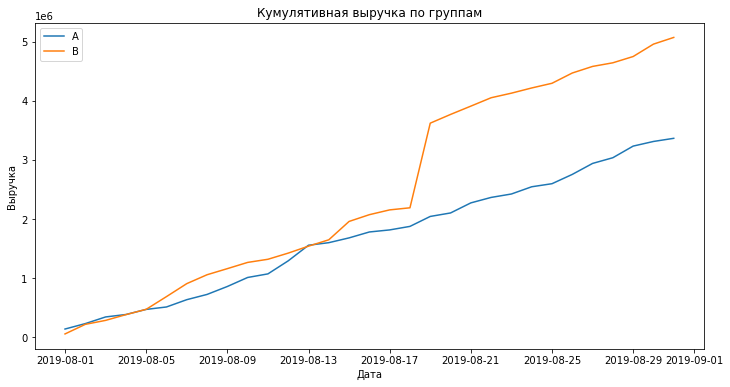

In [17]:
datesGroups = orders[['date', 'group']].drop_duplicates()

ordersAggregated = datesGroups.apply(
    lambda x: orders[
        np.logical_and(
            orders['date'] <= x['date'], orders['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max',
            'group': 'max',
            'transaction_id': 'nunique',
            'visitor_id': 'nunique',
            'revenue': 'sum',
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])

visitorsAggregated = datesGroups.apply(
    lambda x: visitors[
        np.logical_and(
            visitors['date'] <= x['date'], visitors['group'] == x['group']
        )
    ].agg({'date': 'max', 'group': 'max', 'visitors': 'sum'}),
    axis=1,
).sort_values(by=['date', 'group'])

cumulativeData = ordersAggregated.merge(
    visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group']
)
cumulativeData.columns = [
    'date',
    'group',
    'orders',
    'buyers',
    'revenue',
    'visitors',
]

cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue','orders']]
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue','orders']]

plt.figure(figsize=(12,6))

plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.ylabel('Выручка')
plt.xlabel('Дата')
plt.title('Кумулятивная выручка по группам')
plt.legend()
plt.show()

Группа B на всем протящении теста показывает результат лучше, чем группа A. 13 августа показатели почти сравнялись, но потом с 17 по 21 в группе B опять наблюдается резкий рост. Возможно, на результат влияют аномально большие зааказы.

Рассмотрим данные в разрезе кумулятивного среднего чека

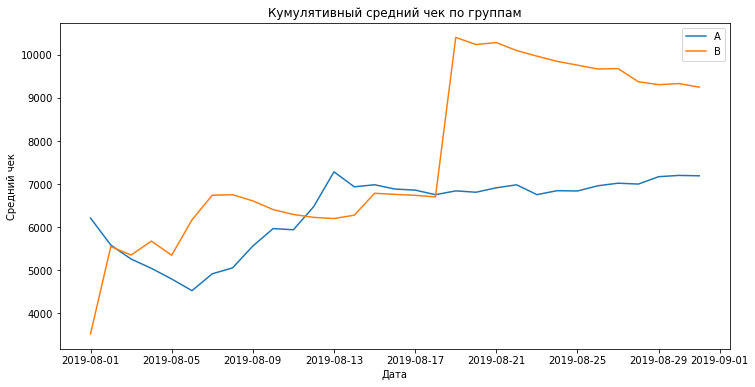

In [18]:
plt.figure(figsize=(12,6))
plt.plot(cumulativeRevenueA['date'],cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'],cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.ylabel('Средний чек')
plt.xlabel('Дата')
plt.title('Кумулятивный средний чек по группам')
plt.legend()
plt.show()

В данных по кумулятивным средним чекам также наблюдается выброс в группе B в районе 19 августа. Похоже, на эту группу вляет какая-то очень большая покупка.

Построим график относительного изменения кумулятивного среднего чека группы B к группе A.

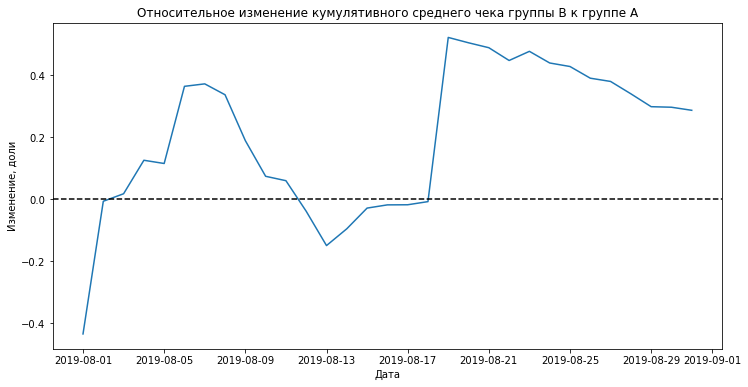

In [19]:
mergedCumulativeRevenue = cumulativeRevenueA.merge(
    cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.figure(figsize=(12,6))
plt.plot(mergedCumulativeRevenue['date'], 
         (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA']) - 1)
plt.axhline(y=0, color='black', linestyle='--')
plt.ylabel('Изменение, доли')
plt.xlabel('Дата')
plt.title('Относительное изменение кумулятивного среднего чека группы B к группе A')
plt.show()

На графике помимо выбороса 19 августа наблюдаются два пика поменьше - 6 и 8 августа.

Посмотрим на график кумулятивного среднего количества заказов по группам

In [20]:
cumulativeData

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,23,19,142779,719
1,2019-08-01,B,17,17,59758,713
2,2019-08-02,A,42,36,234381,1338
3,2019-08-02,B,40,39,221801,1294
4,2019-08-03,A,66,60,346854,1845
...,...,...,...,...,...,...
57,2019-08-29,B,510,490,4746610,17708
58,2019-08-30,A,460,437,3311413,18037
59,2019-08-30,B,531,511,4955833,18198
60,2019-08-31,A,468,445,3364656,18736


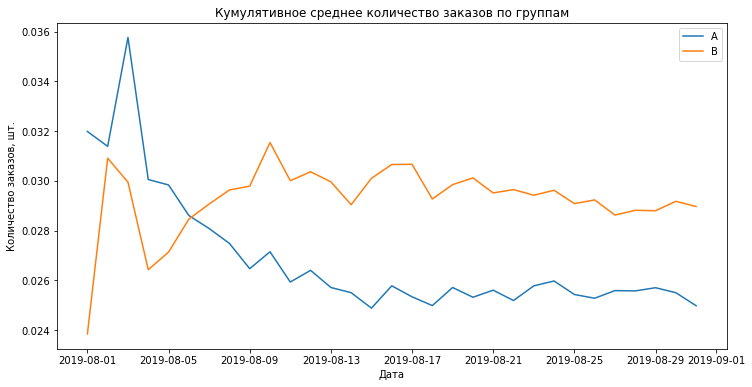

In [21]:
cumulativeOrdersA = cumulativeData[cumulativeData['group']=='A'][['date','visitors','orders']]
cumulativeOrdersB = cumulativeData[cumulativeData['group']=='B'][['date','visitors','orders']]

plt.figure(figsize=(12,6))

plt.plot(cumulativeOrdersA['date'], cumulativeOrdersA['orders']/cumulativeOrdersA['visitors'], label='A')
plt.plot(cumulativeOrdersB['date'], cumulativeOrdersB['orders']/cumulativeOrdersB['visitors'], label='B')
plt.ylabel('Количество заказов, шт.')
plt.xlabel('Дата')
plt.title('Кумулятивное среднее количество заказов по группам')
plt.legend()
plt.show()

В начале наблюдения пользователи из группы А делали значительно больше заказов, 6 августа ситуация меняется коренным образом, и группа B ведет до конца эксперемента

Посмотрим на график относительного изменения кумулятивного среднего количества заказов группы B к группе A

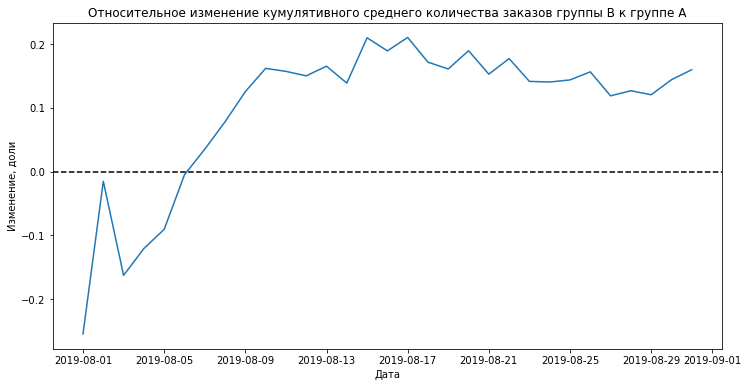

In [22]:
mergedCumulativeOrders = cumulativeOrdersA.merge(
    cumulativeOrdersB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.figure(figsize=(12,6))
plt.plot(mergedCumulativeOrders['date'], 
         (mergedCumulativeOrders['ordersB']/mergedCumulativeOrders['visitorsB'])/(mergedCumulativeOrders['ordersA']/mergedCumulativeOrders['visitorsA']) - 1)
plt.axhline(y=0, color='black', linestyle='--')
plt.ylabel('Изменение, доли')
plt.xlabel('Дата')
plt.title('Относительное изменение кумулятивного среднего количества заказов группы B к группе A')
plt.show()

В начале эксперемента кривая находится ниже нулевой отметки, поскольку лидирует группа А. После 6 августа кривая поднимается выше нуля и показывает относительное изменение в районе 15-20%.

Посмотрим на  точечный график количества заказов по пользователям.

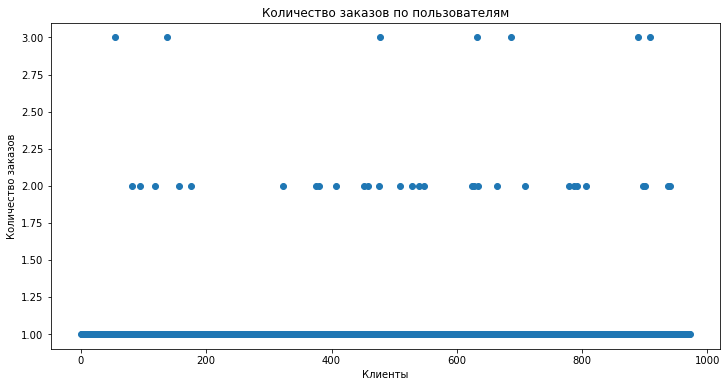

In [23]:
ordersByUsers = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)
ordersByUsers.columns = ['visitor_id', 'orders']

x_values = pd.Series(range(0, len(ordersByUsers)))
plt.figure(figsize=(12,6))
plt.scatter(x_values, ordersByUsers['orders'])
plt.ylabel('Количество заказов')
plt.xlabel('Клиенты')
plt.title('Количество заказов по пользователям')
plt.show()

Подавляющее большинство клиентов делали один заказ, небольшое количество людей сделало 2 или 3 заказа.
<br> Посмотрим на аналогичный график стоимости заказов

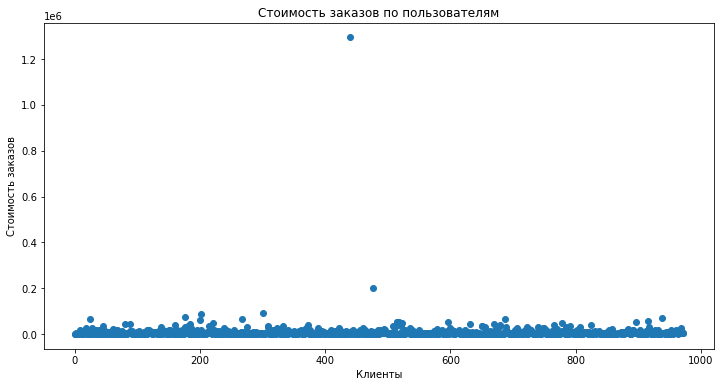

In [24]:
revenueByUsers = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'revenue': 'sum'})
)
revenueByUsers.columns = ['visitor_id', 'revenue']

x_values = pd.Series(range(0, len(revenueByUsers)))
plt.figure(figsize=(12,6))
plt.scatter(x_values, revenueByUsers['revenue'])
plt.ylabel('Стоимость заказов')
plt.xlabel('Клиенты')
plt.title('Стоимость заказов по пользователям')
plt.show()

Стоимость большинства заказов находится в диапазоне ниже 30000, но есть выбросы, превышающие эту сумму в несколько раз.

### Определение экстремумов

Для определения аномальных пользователей посчитаем 95-й и 99-й перцентили количества заказов на пользователя.

In [25]:
np.percentile(ordersByUsers['orders'], [95, 99])

array([1., 2.])

Не более 5% пользователей совершили более 1 заказа. Не более 1% пользователей совершили более 2 заказов. Для того, чтобы убрать выбросы из данных, оставим клиентов, которые сделали 1 заказ.

Сделаем аналогичный расчет для стоимости заказов.

In [26]:
np.percentile(orders['revenue'], [95, 99])

array([26785., 53904.])

Не более 5% пользователей делали заказ на сумму более 27000 и не более 1% на сумму более 54000. 

### Сравнение результатов

Посчитаем статистическую значимость различий в среднем количестве заказов между группами по «сырым» данным. Из-за наличия в данных значительных выбросов считаю правильным использовать для сравнения критерий Манна-Уитни. За статистически значимое отличие примем 0.05
<br>
<br> Сформулируем нулевую и альтернативную гипотезы для первого теста:
- H0: Нет различий между неочищенными данными о среднем количестве заказов в группе A и группе B.
- H1: Неочищенные данные о среднем количестве заказов в группе A и в группе B существенно различаются

In [27]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']] #отфильтровываем клиентов группы А
visitorsADaily.columns = ['date', 'visitorsPerDateA'] #переименовываем столбцы

visitorsACummulative = visitorsADaily.apply(        #считаем количество посетителей в группе A на каждую дату с накоплением
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA'] #переименовываем столбцы для удобства

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']] #отфильтровываем клиентов группы B
visitorsBDaily.columns = ['date', 'visitorsPerDateB'] #переименовываем столбцы

visitorsBCummulative = visitorsBDaily.apply(       #считаем количество посетителей в группе B на каждую дату с накоплением
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB'] #переименовываем столбцы


ordersADaily = (                           #отфтльтровываем заказы клиентов из группы A
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA'] #переименовываем столбцы

ordersACummulative = ordersADaily.apply(              #считаем количество заказов в группе A на каждую дату с накоплением
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = ['date', 'ordersCummulativeA', 'revenueCummulativeA'] #переименовываем столбцы

ordersBDaily = (     #отфтльтровываем заказы клиентов из группы B
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']  #переименовываем столбцы

ordersBCummulative = ordersBDaily.apply(    #считаем количество заказов в группе B на каждую дату с накоплением
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = ['date','ordersCummulativeB', 'revenueCummulativeB'] #переименовываем столбцы

data = ( #объединяем в одну таблицу данные для групп A и B на каждую дату о количестве заказов, 
    ordersADaily.merge(ordersBDaily, left_on='date', right_on='date', how='left')
    .merge(ordersACummulative, left_on='date', right_on='date', how='left') #о количестве заказов с накоплением
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left') #о количестве посетителей
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left') #о количестве посетителей с накоплением
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

ordersByUsersA = ( #группируем данные о заказах по клиентам в группе A
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitor_id', 'orders']

ordersByUsersB = ( #группируем данные о заказах по клиентам в группе B
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitor_id', 'orders']

sampleA = pd.concat(    #создадим таблицу с количеством заказов каждого из пользователей для группы А
    [
        ordersByUsersA['orders'], #выделим список заказов
        pd.Series( #создаем объект Series
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders']) #добавим строки для пользователей, не сделавших ни одного заказа
            ),
            name='orders', #назовем объект
        ),
    ],
    axis=0, #присоединим данные по строкам
)

sampleB = pd.concat( #создадим таблицу с количеством заказов каждого из пользователей для группы B
    [
        ordersByUsersB['orders'], #выделим список заказов
        pd.Series( #создаем объект Series
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders']) #добавим строки для пользователей, не сделавших ни одного заказа
            ),
            name='orders', #назовем объект
        ),
    ],
    axis=0, #присоединим данные по строкам
)

print("p-value {0:.5f}".format(stats.mannwhitneyu(sampleA, sampleB)[1])) #расчитаем p-value с помощью критерия Манна-Уитни и выведем результат на экран

print("Относительное различие между группами {0:.3f}".format(sampleB.mean() / sampleA.mean() - 1)) #расчитаем относительное различие между группами и выведем результат на экран

p-value 0.01102
Относительное различие между группами 0.160


Относительное различие средних заказов между группами - почти 15%. P-value < 0.05, следовательно, опровергаем нулевую гипотезу

Сделаем аналогичный расчет для среднего чека.
- H0: Нет различий между неочищенными данными о среднем чеке в группе A и группе B.
- H1: Неочищенные данные о среднем чеке в группе A и в группе B существенно различаются

In [28]:
print('p-value: {0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('Относительное различие между группами: {0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

p-value: 0.829
Относительное различие между группами: 0.287


Относительное различие среднего чека между сегментами почти 29%. При этом, p-value больше 0.05, то есть, не получилось опровергнуть нулевую теорию и статистически значимых различий между выборками не обнаружено. Стоит изучить те же данные, убрав аномальные выбросы.

Посчитаем статистическую значимость различий в среднем количестве заказов между группами по «очищенным» данным. Для этого отбросим пользователей, совершивших больше одного заказа и заказы на сумму более 27000.
- H0: Нет различий между очищенными данными о среднем количестве заказов в группе A и группе B
- H1: Очищенные данные о среднем количестве заказов в группе A и в группе B существенно различаются

In [29]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 1]['visitor_id'],
        ordersByUsersB[ordersByUsersB['orders'] > 1]['visitor_id'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > 27000]['visitor_id']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)

sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['visitor_id'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['visitor_id'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
) 

print('p-value: {0:.5f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('Относительное различие между группами: {0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)) 

p-value: 0.01593
Относительное различие между группами: 0.174


Относительное различие на очищенных данных даже увеличилось - более 17%. P-value снова ниже уровня статистической значимости, следовательное, отвергаем нулевую теорию - различия между выборками существенны.

Посмотрим, как на очищенных данных выглядят выборки по средним чекам
- H0: Нет различий между очищенными данными о среднем чеке в группе A и группе B
- H1: Очищенные данные о среднем чеке в группе A и в группе B существенно различаются

In [30]:
sampleAFiltered = orders[np.logical_and(orders['group'] == 'A', np.logical_not(orders['visitor_id']
                                                                               .isin(abnormalUsers)))]['revenue']

sampleBFiltered = orders[np.logical_and(orders['group'] == 'B', np.logical_not(orders['visitor_id']
                                                                               .isin(abnormalUsers)))]['revenue']


print('p-value: {0:.3f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('Относительное различие между группами: {0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)) 


p-value: 0.727
Относительное различие между группами: -0.034


Относительное различие между группами составляет -3%, то есть,  группа А показывает результат лучше, чем группа B, но это различие невелико. На неочищенных данных казалось, что группа B показывает выручку на 30% больше, но причиной этой разницы оказались аномальные выбросы, которые случились не под воздействием тестируемых изменений.
P-value выше статистической значимости, значит, нулевую гипотезу о том, что выборки равны, отвергнуть не получится. 

## Вывод

Мы провели по два теста, сравнивая данные о среднем количестве заказов и о средней выручке в группах на сырых и очищенных данных. Результаты тестов выглядят следующим образом:
<br>
<br> Среднее количество заказов:
<br> До удаления экстремумов: Различия между выборками существенны, относительное различие 15%
<br> После удаления экстремумов: Различия существенны, относительное различие 17%
<br>
<br> Средняя выручка:
<br> До удаления экстремумов: Различия между выборками несущественны, относительное различие 29%, что не является статистически значимым, поскольку основная причина возникновения такой разницы - единичные крупные заказы.
<br> После удаления экстремумов: Различия между выборками несущественны, относительное различие -3%
<br>
<br> Анализируя результат теста  можно заключить, что по количеству заказов тест прошел успешно, ведь пользователи в группе, на которой тестировали изменения, сделали на 17% больше заказов, чем контрольная группа. При этом, средняя стоимость заказа в  контрольной группе оказалась больше на 2%. Однако, большее количество заказов, несмотря на небольшое уменьшение среднего чека, приносит больше выручки.
<br> На основании этих данных считаю целесообразным остановить тест и зафиксировать преимущество группы B и эффективность предложенной гипотезы.